In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import keras
start = dt.datetime.now()

Using TensorFlow backend.


In [14]:
STEPS = 512
EPOCHS = 12
size = 256
batchsize = 512

NCATS = {'AreaGraph' : 0, 'BarGraph': 1, 'LineGraph': 2,
         'Map': 3, 'ParetoChart': 4, 'PieChart' : 5,
         'RadarPlot' : 6, 'ScatterGraph' : 7, 'Table':8,
         'VennDiagram' : 9}

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return

In [4]:
model = MobileNet(input_shape=(size, size, 3), alpha=1., weights=None, classes=len(NCATS))
model.compile(optimizer=Adam(lr=0.003),
              loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128       
__________

In [5]:
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = keras.utils.to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [6]:
def decode(datum):
    return np.argmax(datum)

In [7]:
Xtrain = np.load(os.getcwd() + "\\dataset\\" + 'Xtrain.npy')
ytrain = pd.Series(np.load(os.getcwd() + "\\dataset\\" + 'ytrain.npy'))
ytrain = np.array(ytrain.map(NCATS))
# print(ytrain)
ytrain = encode(ytrain)
print(ytrain.shape)

Shape of data (BEFORE encode): (2183,)
Shape of data (AFTER  encode): (2183, 10)

(2183, 10)


In [8]:
Xvalid = np.load(os.getcwd() + "\\dataset\\" + 'Xvalid.npy')
yvalid = pd.Series(np.load(os.getcwd() + "\\dataset\\" + 'yvalid.npy'))
yvalid = yvalid.map(NCATS)
yvalid = np.array(encode(yvalid))
print(yvalid.shape)

Shape of data (BEFORE encode): (730,)
Shape of data (AFTER  encode): (730, 10)

(730, 10)


In [9]:
Xtest = np.load(os.getcwd() + "\\dataset\\" + 'Xtest.npy')
ytest = pd.Series(np.load(os.getcwd() + "\\dataset\\" + 'ytest.npy'))
ytest = ytest.map(NCATS)
ytest = np.array(encode(ytest))
print(ytest.shape)

Shape of data (BEFORE encode): (730,)
Shape of data (AFTER  encode): (730, 10)

(730, 10)


In [10]:
dataset_names = ('Xtrain', 'ytrain','Xvalid','yvalid','Xtest','ytest')


In [11]:
print(Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape, Xtest.shape, ytest.shape)

(2183, 256, 256, 3) (2183, 10) (730, 256, 256, 3) (730, 10) (730, 256, 256, 3) (730, 10)


In [18]:
callbacks = [
#     EarlyStopping(monitor='val_categorical_accuracy', patience=7, min_delta=0.001, mode='max'),
#     ModelCheckpoint('greyscale-mn.model', monitor='val_categorical_accuracy', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005,
                      mode='max', cooldown=3)
]
with tf.device('/gpu:2'):
    hist = model.fit(
        x=Xtrain, y=ytrain, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
        validation_data=(Xvalid, yvalid),
    #     callbacks = callbacks
    )


# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)


Epoch 1/12


InternalError: Dst tensor is not initialized.
	 [[{{node _arg_input_1_0_0/_785}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_8786__arg_input_1_0_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

####### Matrix size: 500 #######
####### Calculating on the /gpu:0 #######
Time taken: 9.804179191589355
####### Calculating on the /cpu:0 #######
Time taken: 3.2348103523254395
####### Matrix size: 550 #######
####### Calculating on the /gpu:0 #######
Time taken: 0.2865734100341797
####### Calculating on the /cpu:0 #######
Time taken: 3.894771099090576
####### Matrix size: 600 #######
####### Calculating on the /gpu:0 #######
Time taken: 0.25284242630004883
####### Calculating on the /cpu:0 #######
Time taken: 5.120824575424194
####### Matrix size: 650 #######
####### Calculating on the /gpu:0 #######
Time taken: 0.3191490173339844
####### Calculating on the /cpu:0 #######
Time taken: 6.445727825164795
####### Matrix size: 700 #######
####### Calculating on the /gpu:0 #######
Time taken: 0.25077176094055176
####### Calculating on the /cpu:0 #######
Time taken: 9.217475891113281
####### Matrix size: 750 #######
####### Calculating on the /gpu:0 #######
Time taken: 0.2635791301727295
##

Text(0, 0.5, 'Time')

Text(0.5, 0, 'Matrix size')

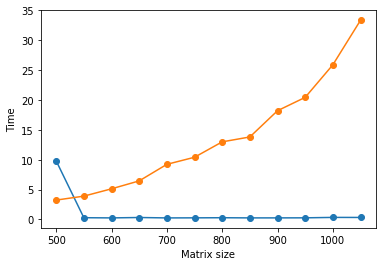

In [19]:
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def get_times(maximum_time):

    device_times = {
        "/gpu:0":[],
        "/cpu:0":[]
    }
    matrix_sizes = range(500,50000,50)

    for size in matrix_sizes:
        print("####### Matrix size: " + str(size) + " #######")
        for device_name in device_times.keys():

            print("####### Calculating on the " + device_name + " #######")

            shape = (size,size)
            data_type = tf.float16
            with tf.device(device_name):
                r1 = tf.random_uniform(shape=shape, minval=0, maxval=1, dtype=data_type)
                r2 = tf.random_uniform(shape=shape, minval=0, maxval=1, dtype=data_type)
                dot_operation = tf.matmul(r2, r1)

            with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as session:
                    start_time = time.time()
                    result = session.run(dot_operation)
                    time_taken = time.time() - start_time
                    #print(result)
                    device_times[device_name].append(time_taken)
            print("Time taken:", time_taken)

            if time_taken > maximum_time:
                return device_times, matrix_sizes

device_times, matrix_sizes = get_times(30) # Change the number to specify maximum cut-off compute time (in seconds) after which the comparison script is terminated and results displayed.
print(device_times)
gpu_times = device_times["/gpu:0"]
cpu_times = device_times["/cpu:0"]

plt.plot(matrix_sizes[:len(gpu_times)], gpu_times, 'o-')
plt.plot(matrix_sizes[:len(cpu_times)], cpu_times, 'o-')
plt.ylabel('Time')
plt.xlabel('Matrix size')
plt.show()